# Illumination Analysis 2

In [32]:
import sys
import os
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1
sys.path.append('/home/jferna27/project/stylegan2-ada-josefa')
import dnnlib

In [33]:
#suppress StyleGAN2 plugin warnings that appear before to see better the output (this warning occurs when loading the model and during synthesis calls, )
import io
import contextlib
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='torch_utils') #it occurs due to StyleGAN2 plugins, it can be ignored because it does not affect the results
warnings.filterwarnings('ignore', message='.*upfirdn2d.*') #it occurs due to upfirdn2d plugin,ignored
warnings.filterwarnings('ignore', message='.*CUDA kernels.*') #it occurs when the CUDA kernels are compiled, ignored

## 1. Setup

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_grad_enabled(False)
torch.backends.cudnn.benchmark = False
print(f"Using device: {device}")

Using device: cuda:0


## Load StyleGAN2-ADA

In [35]:
with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()): #suppress stdout/stderr during model loading to hide plugin messages
    network_url = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
    with dnnlib.util.open_url(network_url) as f:
        G = pickle.load(f)["G_ema"].to(device).eval()
    print("Generator loaded")

Projection imgs

## 2. Load projections

In [36]:
proj_root = "../../stylegan2-ada-josefa/out_proj_2"
w_plus_list = []

for root, dirs, files in os.walk(proj_root):
    for file in sorted(files):
        if file.endswith('.npz'):
            w = np.load(os.path.join(root, file))["w"]
            w_plus_list.append(torch.tensor(w, device=device))
print("Loaded projections:", len(w_plus_list))

Loaded projections: 5


## 3. Detect face + Extract embeddings

In [37]:
device = torch.device('cpu')

print("Loading MTCNN for face detection...")
mtcnn = MTCNN(keep_all=True, device=device)

print("Loading FaceNet (InceptionResnetV1) for embeddings...")
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

Loading MTCNN for face detection...
Loading FaceNet (InceptionResnetV1) for embeddings...


In [38]:
def synthesize(w_plus):
    with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()): #suppress plugin compilation messages on first synthesis call
        img = G.synthesis(w_plus, noise_mode="const")
    return (img + 1) / 2

In [39]:
def get_embedding_mtcnn_facenet(img_tensor):
    img_np = (img_tensor[0].permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    img_pil = Image.fromarray(img_np)
    try:
        boxes, probs = mtcnn.detect(img_pil)
        if boxes is not None and len(boxes) > 0 and probs is not None:
            best_idx = np.argmax(probs)
            img_cropped_list = mtcnn(img_pil, return_prob=False)
            if img_cropped_list is not None and len(img_cropped_list) > best_idx:
                face_tensor = img_cropped_list[best_idx:best_idx+1]
                with torch.no_grad():
                    embedding = facenet(face_tensor.to("cpu"))
                return embedding.cpu().numpy()[0]
        return None
    except Exception:
        return None

In [40]:
print("\nExtracting embeddings from all generated images...")
#calculate luminance
luminances = []
embeddings = []
for i, w_plus in enumerate(tqdm(w_plus_list)):
    img = synthesize(w_plus)
    img_np = img[0].permute(1, 2, 0).cpu().numpy()
    lum = 0.299 * img_np[:,:,0] + 0.587 * img_np[:,:,1] + 0.114 * img_np[:,:,2]
    mean_lum = lum.mean()
    luminances.append(mean_lum)
    #extract embedding
    emb = get_embedding_mtcnn_facenet(img.cpu())
    if emb is not None:
        embeddings.append((i, luminances[-1], emb))


Extracting embeddings from all generated images...


100%|██████████| 5/5 [00:00<00:00,  5.64it/s]


## 4. H1 directional consistency in the embeddings by illumination

#### Embedding Displacements

In [41]:
# reference embedding index is the image number 3
emb_ref_idx = 3
emb_ref = None
for (i, lum, emb) in embeddings:
    if i == emb_ref_idx:
        emb_ref = emb

In [42]:
deltas = []
lum_diffs = []
for (i, lum, emb) in embeddings:
    if i != emb_ref_idx:
        delta = emb - emb_ref
        delta = delta / (np.linalg.norm(delta))
        deltas.append(delta)
        lum_diffs.append(lum - luminances[emb_ref_idx])

#### Directional consistency H1

In [43]:
sims = []
for i in range(len(deltas)):
    for j in range(i+1, len(deltas)):
        sim = cosine_similarity(deltas[i].reshape(1,-1), deltas[j].reshape(1,-1))[0,0]
        sims.append(sim)
print(f"H1 (mean directional illumination consistency): {np.mean(sims)}")

H1 (mean directional illumination consistency): 0.21646247804164886


## 5. Luminance vs displacement

/home/jferna27/.local/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/jferna27/.local/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


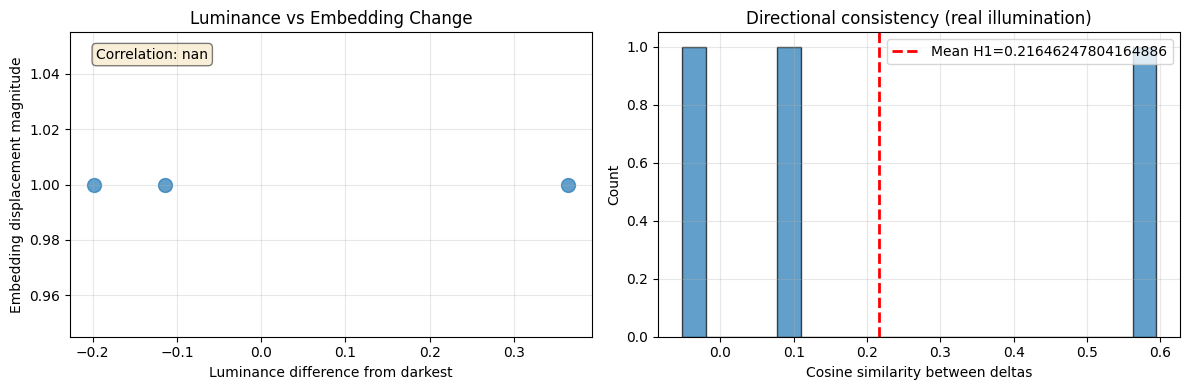

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

delta_mags = [np.linalg.norm(delta) for delta in deltas]
ax1.scatter(lum_diffs, delta_mags, s=100, alpha=0.7)
ax1.set_xlabel('Luminance difference from darkest')
ax1.set_ylabel('Embedding displacement magnitude')
ax1.set_title('Luminance vs Embedding Change')
ax1.grid(True, alpha=0.3)
if len(lum_diffs) > 1:
    corr = np.corrcoef(lum_diffs, delta_mags)[0,1]
    ax1.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax1.transAxes,va='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax2.hist(sims, bins=20, alpha=0.7, edgecolor='black')
ax2.axvline(np.mean(sims), color='red', linestyle='--', linewidth=2, label=f'Mean H1={np.mean(sims)}')
ax2.set_xlabel('Cosine similarity between deltas')
ax2.set_ylabel('Count')
ax2.set_title('Directional consistency (real illumination)')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Order by luminance and info

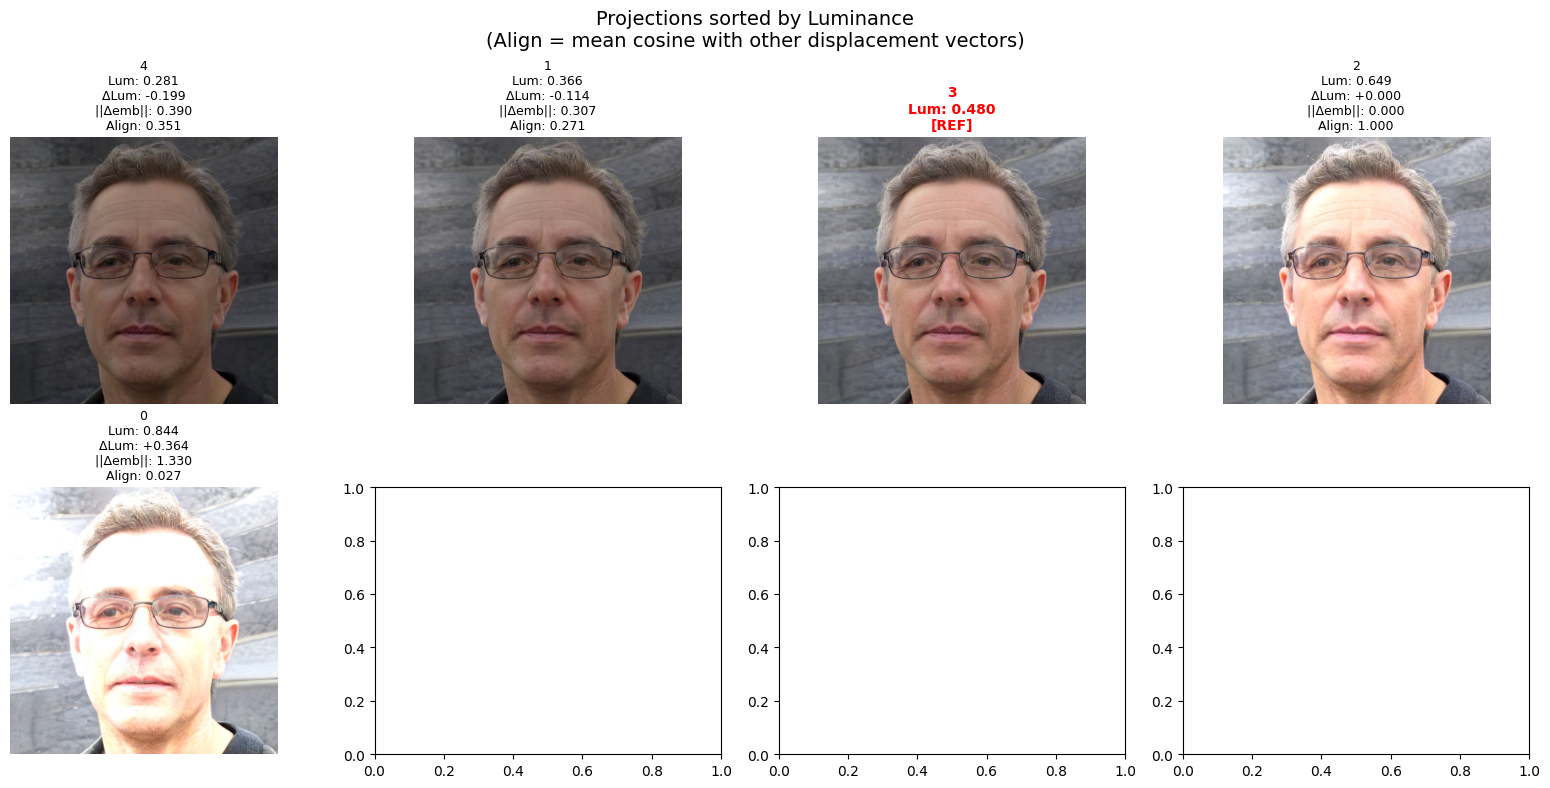

In [45]:
sorted_indices = np.argsort(luminances)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for plot_idx, idx in enumerate(sorted_indices):
    if plot_idx >= 7:
        break
    img = synthesize(w_plus_list[idx])
    img_np = img[0].permute(1, 2, 0).cpu().numpy()
    img_np = np.clip(img_np, 0, 1)
    emb_current = None

    for (i, lum, emb) in embeddings:
        if i == idx:
            emb_current = emb
            break
    emb_ref = None
    for (i, lum, emb) in embeddings:
        if i == emb_ref_idx:
            emb_ref = emb
            break

    if emb_current is not None and emb_ref is not None and idx != emb_ref_idx:
        delta_mag = np.linalg.norm(emb_current - emb_ref)
        lum_diff = luminances[idx] - luminances[emb_ref_idx]
        delta_normalized = (emb_current - emb_ref) / (np.linalg.norm(emb_current - emb_ref) + 1e-8)
        cos_with_others = []
        for other_idx in sorted_indices:
            if other_idx != idx and other_idx != emb_ref_idx:
                emb_other = None
                for (i, lum, emb) in embeddings:
                    if i == other_idx:
                        emb_other = emb
                        break
                if emb_other is not None:
                    delta_other = (emb_other - emb_ref) / (np.linalg.norm(emb_other - emb_ref) + 1e-8)
                    cos = cosine_similarity(delta_normalized.reshape(1,-1), delta_other.reshape(1,-1))[0,0]
                    cos_with_others.append(cos)
        mean_cos = np.mean(cos_with_others) if len(cos_with_others) > 0 else 0.0
    else:
        delta_mag = 0.0
        lum_diff = 0.0
        mean_cos = 1.0

    axes[plot_idx].imshow(img_np)
    axes[plot_idx].axis('off')
    info_text = f"{idx}\nLum: {luminances[idx]:.3f}"
    if idx == emb_ref_idx:
        info_text += "\n[REF]"
        axes[plot_idx].set_title(info_text, fontsize=10, color='red', weight='bold')
    else:
        info_text += f"\nΔLum: {lum_diff:+.3f}\n||Δemb||: {delta_mag:.3f}\nAlign: {mean_cos:.3f}"
        axes[plot_idx].set_title(info_text, fontsize=9)

if len(sorted_indices) == 7:
    axes[7].axis('off')

plt.suptitle('Projections sorted by Luminance\n(Align = mean cosine with other displacement vectors)', fontsize=14)
plt.tight_layout()
plt.show()

/tmp/ipykernel_111922/852550743.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  ax1.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], c=color, s=size, marker=marker,


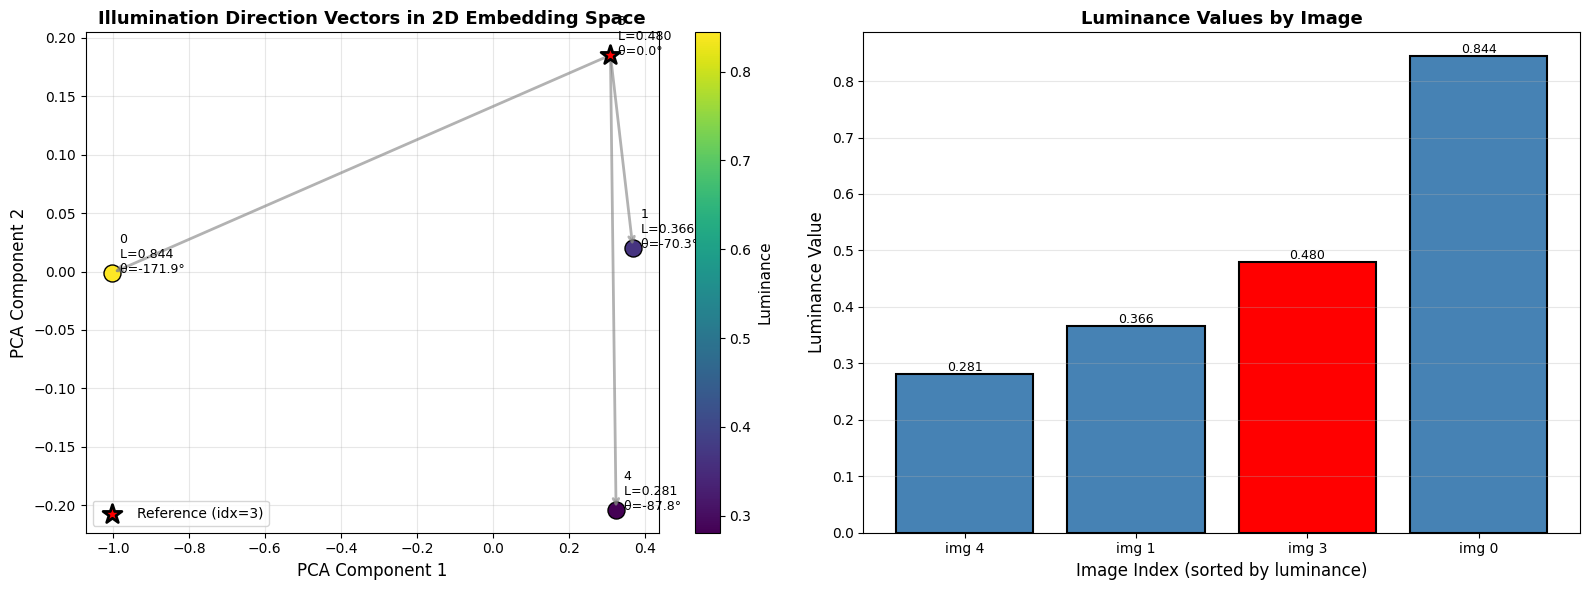

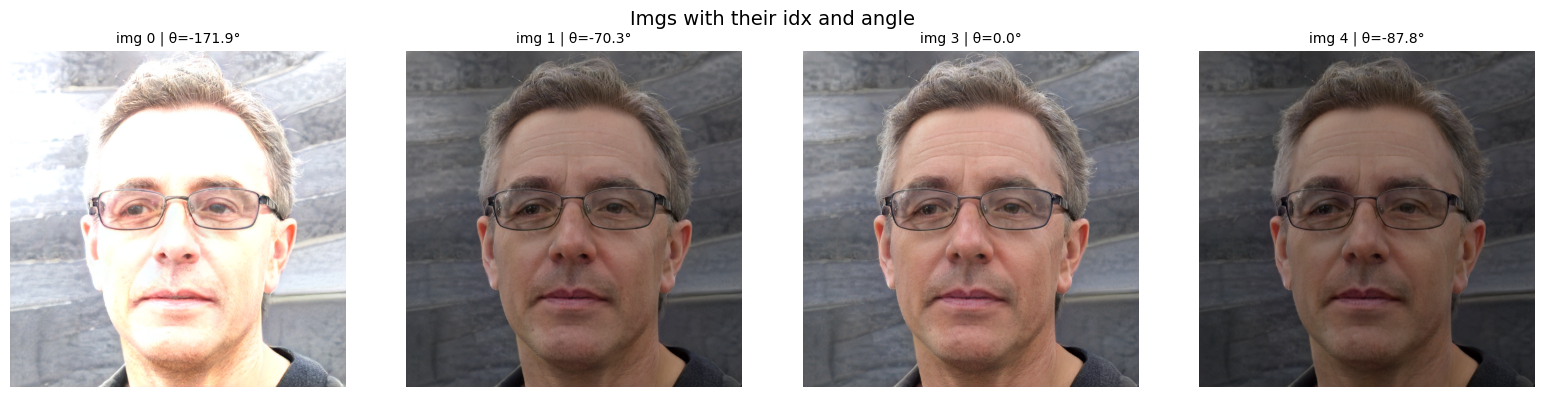


PCA explained variance: [0.92119306 0.05232814]
Total variance explained: 0.9735212065279484


In [52]:
emb_ref = None
for (i, lum, emb) in embeddings:
    if i == emb_ref_idx:
        emb_ref = emb #reference embedding
        break

#PCA to reduce embeddings to 2D for visualization
all_embeddings = np.array([emb for (i, lum, emb) in embeddings])
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(all_embeddings)

directions = []
emb_ref_2d = None #arrow start point reference img
for idx_ref, (i_ref, _, _) in enumerate(embeddings):
    if i_ref == emb_ref_idx:
        emb_ref_2d = embeddings_2d[idx_ref]
        break

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
#direction vectors in 2D embedding space
for idx, (i, lum, emb) in enumerate(embeddings):
    vec_2d = embeddings_2d[idx] - emb_ref_2d if emb_ref_2d is not None else np.array([0.0, 0.0])
    dist_2d = float(np.linalg.norm(vec_2d))
    angle_deg = float(np.degrees(np.arctan2(vec_2d[1], vec_2d[0]))) if dist_2d > 1e-8 else 0.0
    is_ref = (i == emb_ref_idx)
    marker = '*' if is_ref else 'o'
    size = 200 if is_ref else 150
    color = 'red' if is_ref else lum
    ax1.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], c=color, s=size, marker=marker,
               cmap='viridis', vmin=min(luminances), vmax=max(luminances),
               edgecolors='black', linewidths=2 if is_ref else 1,
               label=f'Reference (idx={emb_ref_idx})' if is_ref else None, zorder=5 if is_ref else 3)
    if not is_ref and emb_ref_2d is not None:
        ax1.annotate('', xy=(embeddings_2d[idx, 0], embeddings_2d[idx, 1]), 
                    xytext=(emb_ref_2d[0], emb_ref_2d[1]),
                    arrowprops=dict(arrowstyle='->', lw=2, color='gray', alpha=0.6))
    ax1.text(embeddings_2d[idx, 0], embeddings_2d[idx, 1], f'  {i}\n  L={lum:.3f}\n  θ={angle_deg:.1f}°', 
            fontsize=9, ha='left')
    directions.append((i, lum, angle_deg, dist_2d))
ax1.set_xlabel('PCA Component 1', fontsize=12)
ax1.set_ylabel('PCA Component 2', fontsize=12)
ax1.set_title('Illumination Direction Vectors in 2D Embedding Space', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=min(luminances), vmax=max(luminances)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Luminance', fontsize=11)
#luminance values with image indices
sorted_data = sorted([(i, lum, emb) for (i, lum, emb) in embeddings], key=lambda x: x[1])
indices = [i for (i, lum, emb) in sorted_data]
lums = [lum for (i, lum, emb) in sorted_data]
colors = ['red' if i == emb_ref_idx else 'steelblue' for i in indices]
bars = ax2.bar(range(len(indices)), lums, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_xticks(range(len(indices)))
ax2.set_xticklabels([f'img {i}' for i in indices], fontsize=10)
ax2.set_ylabel('Luminance Value', fontsize=12)
ax2.set_xlabel('Image Index (sorted by luminance)', fontsize=12)
ax2.set_title('Luminance Values by Image', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for idx, (bar, lum) in enumerate(zip(bars, lums)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{lum:.3f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

#imgs with their idx and angle to relate img to data in plot
angle_dict = {i: ang for i, _, ang, _ in directions}
num_show = min(len(embeddings), 12)
cols = 4
rows = int(np.ceil(num_show / cols))
fig_thumb, axes_thumb = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes_thumb = axes_thumb.flatten() if num_show > 1 else [axes_thumb]
for idx_plot, (i, lum, emb) in enumerate(embeddings[:num_show]):
    ax = axes_thumb[idx_plot]
    img = synthesize(w_plus_list[i])
    img_np = img[0].permute(1, 2, 0).cpu().numpy()
    img_np = np.clip(img_np, 0, 1)
    ax.imshow(img_np)
    theta = angle_dict.get(i, 0.0)
    ax.set_title(f'img {i} | θ={theta:.1f}°', fontsize=10)
    ax.axis('off')
for k in range(num_show, len(axes_thumb)):
    axes_thumb[k].axis('off')
plt.suptitle('Imgs with their idx and angle', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nPCA explained variance: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_)}")

It did not detect 1 face.